Links

In [ ]:
# This project takes in phishing links data and trains models
# These models will detect if a link is phishing
# We will then extrapolate extra inforamtion about these links

In [ ]:
#this notebook required sklearn 1.3.2
#!pip uninstall scikit-learn
#!pip install scikit-learn==1.3.2

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/scikit_learn-1.2.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/sklearn/*
Proceed (Y/n)? y
  Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 16.4 MB/s eta 0:00:00


In [ ]:
import sklearn
print(sklearn.__version__)

1.3.2


In [ ]:
#Data:
#https://data.mendeley.com/datasets/c2gw7fy2j4/3
#https://data.mendeley.com/datasets/72ptz43s9v/1
#https://www.kaggle.com/datasets/danielfernandon/web-page-phishing-dataset

Files

Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn as skl
import statistics
from scipy import stats
from sklearn.model_selection import KFold, train_test_split as tts
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import pointbiserialr as pbsr

Data Cleanup

In [ ]:
# Imports the data from the from collab files
data_set_1 = r"data_set_1.txt"
data_set_2 = r"data.txt"

# Creates a dataframe using the first data set
df1 = pd.read_csv(data_set_1, header=0, sep=',')

print(df1.columns)

# Lists out the column headers
column= ["dot", "hyphen", "underline", "slash", "questionmark", "equal", "at",
        "and", "space", "tilde", "comma", "asterisk", "dollar", "percent",
        "length", "redirects", "phishing"]

# Reindexes the first dataset dataframe, so both the first and second dataframe
# have headers in the same position
df1 = df1.reindex(column, axis='columns')

# Creates a dataframe using the secoind dataset
df2 = pd.read_csv(data_set_2, header=0, sep=',')

print("df1 shape:", df1.shape, "df2 shape:", df2.shape, "\n")

# Merges the two dataframes
lst = [df1, df2]
df = pd.concat(lst, ignore_index = True)

df

Index(['length', 'dot', 'hyphen', 'at', 'questionmark', 'and', 'equal',
       'underline', 'tilde', 'percent', 'slash', 'asterisk', 'comma', 'dollar',
       'space', 'redirects', 'phishing'],
      dtype='object')
df1 shape: (11430, 17) df2 shape: (58645, 17) 



,dot,hyphen,underline,slash,questionmark,equal,at,and,space,tilde,comma,asterisk,dollar,percent,length,redirects,phishing
0,6.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0.0,0
1,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,1.0,1
2,4.0,1.0,2.0,5.0,1.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,126.0,1.0,1
3,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,1.0,0
4,2.0,2.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70070,1.0,0.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,1
70071,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0
70072,5.0,6.0,3.0,6.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,161.0,0.0,1
70073,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,1.0,0


Modeling

In [ ]:
# Imports and runs six different models in order to test the most
# effective ones
quant_models = {}

# Logistic Regression Model
from sklearn.linear_model import LogisticRegression
quant_models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines Model
from sklearn.svm import LinearSVC
quant_models['Support Vector Machines'] = LinearSVC()

# Decision Trees Model
from sklearn.tree import DecisionTreeClassifier
quant_models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest Model
from sklearn.ensemble import RandomForestClassifier
quant_models['Random Forest'] = RandomForestClassifier()

# Naive Bayes Model
from sklearn.naive_bayes import GaussianNB
quant_models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors Model
from sklearn.neighbors import KNeighborsClassifier
quant_models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [ ]:
# Creates a list of the dataframe's features and creates the label var
FEATURES = ['dot', 'hyphen', 'underline', 'slash', 'questionmark', 'equal',
      'at', 'and', 'space', 'tilde', 'comma', 'asterisk', 'dollar', 'percent',
       'length', 'redirects']
LABELS = "phishing"

In [ ]:
# Train test split the dataset with 25% train size and 10% test size
X = df[FEATURES]
y = df[LABELS]

train_X, val_X, train_y, val_y = tts(X, y, random_state=0, train_size=0.25,
                                     test_size=0.1)

In [ ]:
# normalize x values across the train test split
ss_train = StandardScaler()
train_X = ss_train.fit_transform(train_X)

ss_test = StandardScaler()
val_X = ss_test.fit_transform(val_X)

In [ ]:
# Takes in a model and the training/testing data
# Outputs the corresponding recall, acc, precision and f1 scores
def train_predict_validate(models, train_X, val_X, train_y, val_y):
  accuracy, precision, recall, f1 = {}, {}, {}, {}
  for key in models.keys():
    models[key].fit(train_X, train_y)
    predictions = models[key].predict(val_X)

    accuracy[key] = accuracy_score(predictions, val_y)
    precision[key] = precision_score(predictions, val_y)
    recall[key] = recall_score(predictions, val_y)
    f1[key] = skl.metrics.f1_score(predictions, val_y)

  return accuracy, precision, recall, f1

In [ ]:
# predict with and validate the models
a_score, p_score, r_score, f_score = train_predict_validate(quant_models,
                                                train_X, val_X, train_y, val_y)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Text(0.5, 0.98, 'AP&R Plot for Various Supervised Models')

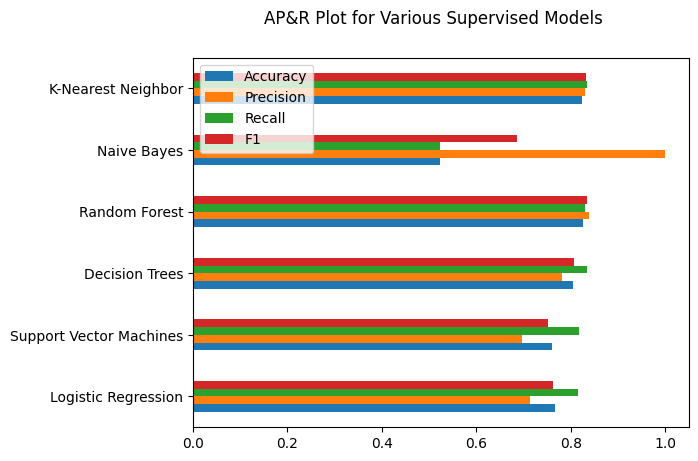

In [ ]:
# Creates bar plot of all the models scores using train_predit_validate function
quant_models_df = pd.DataFrame(index=quant_models.keys(), columns=['Accuracy',
                                                        'Precision', 'Recall'])
quant_models_df['Accuracy'] = a_score.values()
quant_models_df['Precision'] = p_score.values()
quant_models_df['Recall'] = r_score.values()
quant_models_df['F1'] = f_score.values()

# Builds the graph and makes a legened and title for it
apr_plot = quant_models_df.plot.barh()
apr_plot.legend(loc='upper left')
plt.suptitle("AP&R Plot for Various Supervised Models")

In [ ]:
# Return a dictionary with model metrics as the keys
# The values are the metrics's scores
def custom_make_scorer(metric, avg='binary', zd=np.nan):
    scorers = {"accuracy" : make_scorer(accuracy_score),
               "precision" : make_scorer(precision_score, average=avg,
                                         zero_division=zd),
               "recall" : make_scorer(recall_score, average=avg,
                                      zero_division=zd),
               "f_one" : make_scorer(f1_score, average=avg,
                                      zero_division=zd)}
    return scorers[metric]

In [ ]:
# Gets all the keys which have values that are equal to val
def get_key_from_val(dct, val):
    if val not in dct.values(): return None
    return list(dct.keys())[list(dct.values()).index(val)]

In [ ]:
# Splits the data set in half, and seperates the features and labels
df_smpl = df.sample(frac=0.50)
X_smpl = df_smpl[FEATURES]
y_smpl = df_smpl[LABELS]

In [ ]:
# Normalizes the split dataset
ss_smpl = StandardScaler()
X_smpl = ss_smpl.fit_transform(X_smpl)

In [ ]:
# Plots a dictionary with the keys as x pos and values as y pos
def plot_dcts(dcts, title, x_label, y_label):
    for key in dcts.keys():
        plt.plot(list(dcts[key].keys()), list(dcts[key].values()), label=key)
    plt.title(title), plt.xlabel(x_label), plt.ylabel(y_label)
    plt.legend()
    plt.show()

In [ ]:
# Finds the best value of k in a KNN model
# Using KNeighbors, kfold and cross_validate to create scores
# Returns the max average cross validate score
def find_best_k(k_vals, X, y, scoring):
    scores = {}
    for k in k_vals:
        model = KNeighborsClassifier(n_neighbors=k)
        cv = KFold(random_state=0, shuffle=True)
        score = cross_validate(model, X, y,
                               scoring=custom_make_scorer(scoring),
                               cv=cv, error_score=0)
        scores[k] = np.mean(score['test_score'])
    return get_key_from_val(scores, max(scores.values())), scores

In [ ]:
# Find best k and corresponding score for each metric using find_best_k function
k_candidates = [4, 5, 6, 7, 8, 9, 10]

knn_ks, knn_scores = {}, {}
for metric in ["accuracy", "precision", "recall", "f_one"]:
  knn_ks[metric], knn_scores[metric] = find_best_k(k_candidates, X_smpl, y_smpl,
                                                   metric)
  print(metric, "complete")

accuracy complete
precision complete
recall complete
f_one complete


In [ ]:
# Prints all KNN scores
print(knn_ks)

{'accuracy': 9, 'precision': 4, 'recall': 9, 'f_one': 9}


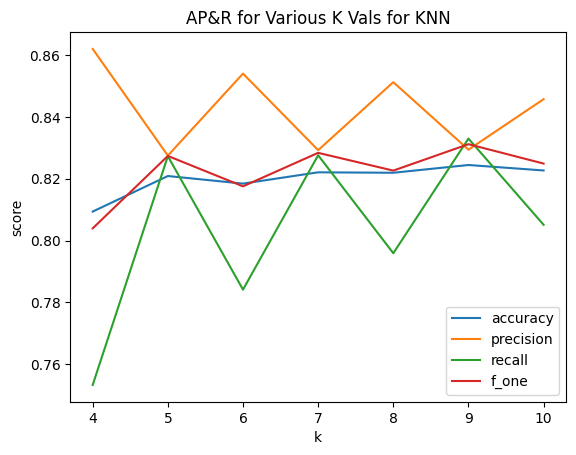

In [ ]:
# Plots the K Nearest Neighbor scores for each scoring metric
# Uses k for x values
plot_dcts(knn_scores, "AP&R for Various K Vals for KNN", "k", "score")

In [ ]:
# Finds the best depth value(n) in a the RFC model
# Using RandomForestClassifier, kfold and cross_validate to create scores
# Returns the max average cross validate score
def find_best_depth(n_vals, X, y, scoring):
    scores = {}
    for n in n_vals:
        model = RandomForestClassifier(max_depth=n)
        cv = KFold(random_state=0, shuffle=True)
        score = cross_validate(model, X, y,
                               scoring=custom_make_scorer(scoring),
                               cv=cv, error_score=0)
        scores[n] = np.mean(score['test_score'])
    return get_key_from_val(scores, max(scores.values())), scores

In [ ]:
# Find best n and corresponding score for each metric
# Uses the find_best_depth function
depth_candidates = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

rfc_ns, rfc_scores = {}, {}
for metric in ["accuracy", "precision", "recall", "f_one"]:
  rfc_ns[metric], rfc_scores[metric] = find_best_depth(depth_candidates, X_smpl, y_smpl, metric)
  print(metric, "complete")

accuracy complete
precision complete
recall complete
f_one complete


In [ ]:
# Prints all RFC scores
print(rfc_ns)

{'accuracy': 15, 'precision': 15, 'recall': 12, 'f_one': 15}


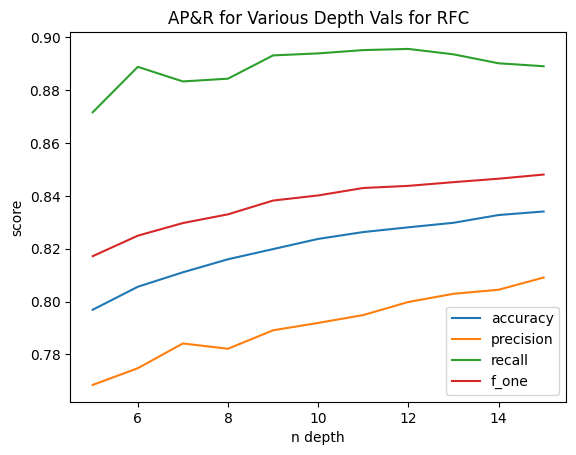

In [ ]:
# Plots the RandomForestClassifier scores for each scoring metric
# Uses n depth as x values
plot_dcts(rfc_scores, "AP&R for Various Depth Vals for RFC", "n depth", "score")

In [ ]:
# Train test split on all the data
train_X, test_X, train_y, test_y = tts(X, y, random_state=0)

In [ ]:
# Noramlizes the train test split data
ss_train = StandardScaler()
train_X = ss_train.fit_transform(train_X)

ss_test = StandardScaler()
test_X = ss_test.fit_transform(test_X)

In [ ]:
# Creates a KNN prediction model
#uses best k value (9)
knn_full = KNeighborsClassifier(n_neighbors=9)
knn_full.fit(train_X, train_y)
knn_preds = knn_full.predict(test_X)

In [ ]:
# Prints the classification report of the knn model
print(classification_report(test_y, knn_preds,
          zero_division=np.nan))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      8447
           1       0.83      0.83      0.83      9072

    accuracy                           0.82     17519
   macro avg       0.82      0.82      0.82     17519
weighted avg       0.82      0.82      0.82     17519



Text(0.5, 1.0, 'Confusion Heatmap for KNN Model of Data')

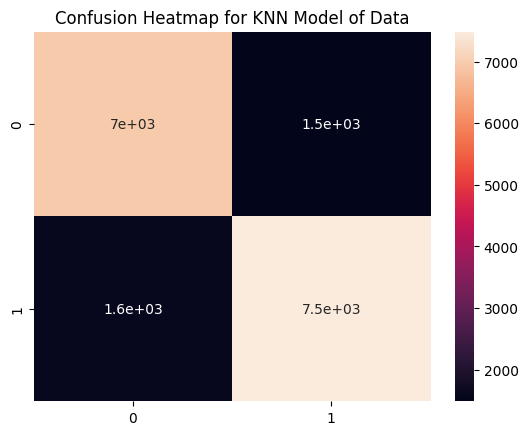

In [ ]:
# Creates a confusion matrix for the knn model
# Graphs the confusion matrix and creates a title
confusion = confusion_matrix(test_y, knn_preds)
sns.heatmap(confusion, annot=True)
plt.title("Confusion Heatmap for KNN Model of Data")

In [ ]:
# Creates a RandomForestClassifier prediction model
# Uses the best n depth (7)
rfc_full = RandomForestClassifier(max_depth=7)
rfc_full.fit(train_X, train_y)
rfc_preds = rfc_full.predict(test_X)

In [ ]:
# Prints the classification report of the RFC model
print(classification_report(test_y, rfc_preds,
          zero_division=np.nan))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79      8447
           1       0.79      0.87      0.83      9072

    accuracy                           0.81     17519
   macro avg       0.82      0.81      0.81     17519
weighted avg       0.82      0.81      0.81     17519



Text(0.5, 1.0, 'Confusion Heatmap for RFC Model of Data')

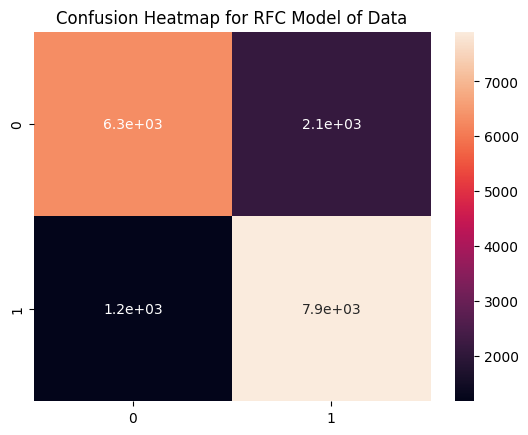

In [ ]:
# Creates a confusion matrix for the RFC model
# Graphs the confusion matrix and creates a title
confusion = confusion_matrix(test_y, rfc_preds)
sns.heatmap(confusion, annot=True)
plt.title("Confusion Heatmap for RFC Model of Data")

Exploration

In [ ]:
#run at your own risk
#sns.pairplot(df, hue='phishing')

In [ ]:
# Finds strong predictor of a phishing link using correlation
# Returns both strong and weak predictors, using their labels
# Also returns the strength of the predictors
def quant_corr_w_approved(df, features, label, thresh=0.3):
    strong_preds, weak_preds = {}, {}

    for feature in features:
        r, p = pbsr(df[label], df[feature])
        if abs(r) >= thresh: strong_preds[feature] = r
        else: weak_preds[feature] = r

    return strong_preds, weak_preds

In [ ]:
# Creates copy of the dataframe, normalizes it and trains the data
df_std = df
ss_full = StandardScaler()
df_std[FEATURES] = ss_train.fit_transform(df[FEATURES])

In [ ]:
# Determines if features are weak or strong
# Prints out the strength of the predictors
sp, wp = quant_corr_w_approved(df_std, FEATURES, LABELS)
print("quantitave variables:\n")
print("\tgood/strong predictors:", sp, "\n")
print("\tweak/moderate predictors:", wp, "\n\n")

quantitave variables:

	good/strong predictors: {'slash': 0.4926391327258953, 'length': 0.3559133001583715} 

	weak/moderate predictors: {'dot': 0.14957333646353732, 'hyphen': 0.08018794981260506, 'underline': 0.12472007872129001, 'questionmark': 0.13870422637261992, 'equal': 0.21833401943937913, 'at': 0.09489554613334739, 'and': 0.16009502726876243, 'space': 0.004427643958303378, 'tilde': 0.03995000604917675, 'comma': 0.01938033698703376, 'asterisk': 0.016597530577672076, 'dollar': 0.022428635334863174, 'percent': 0.0060641683700784045, 'redirects': -0.033551952272913035} 




In [ ]:
# Creates a copy of the dataframe, getting rid of outliers
# Seperates the new dataframe by labels
new_df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
phishing_df = new_df.loc[new_df[LABELS] == 1, 'length']
real_df = new_df.loc[new_df[LABELS] == 0, 'length']

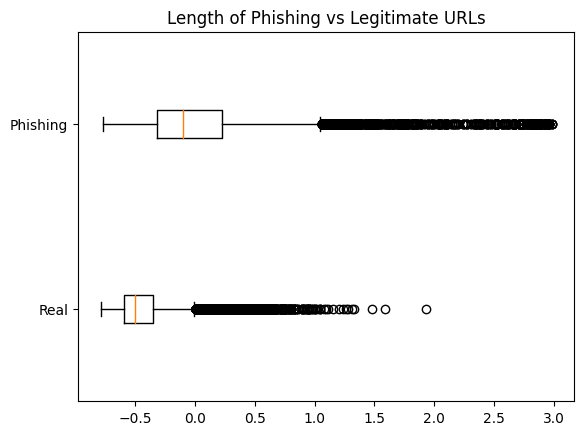

In [ ]:
# Plots a box plot of the length of both Phishing and legitimate URLs
# X labels are the z-score of the length
plots = [real_df, phishing_df]
bp = plt.boxplot(plots, vert = 0, labels = ["Real", "Phishing"])
plt.title("Length of Phishing vs Legitimate URLs")
plt.show()

In [ ]:
# Finds what percentage each feature makes up of a URL
real_length = int(sum(df.loc[df[LABELS] == 0, 'length'])) / 100
phish_length = int(sum(df.loc[df[LABELS] == 1, 'length'])) / 100

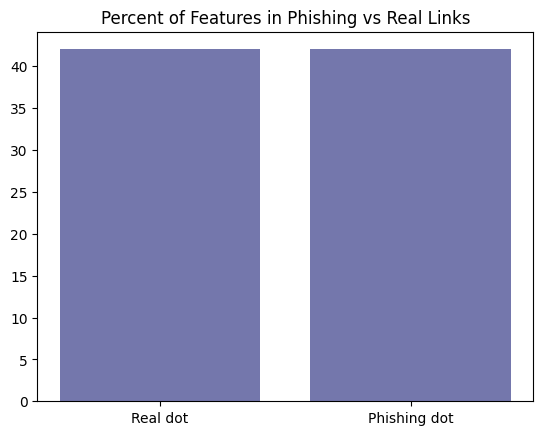

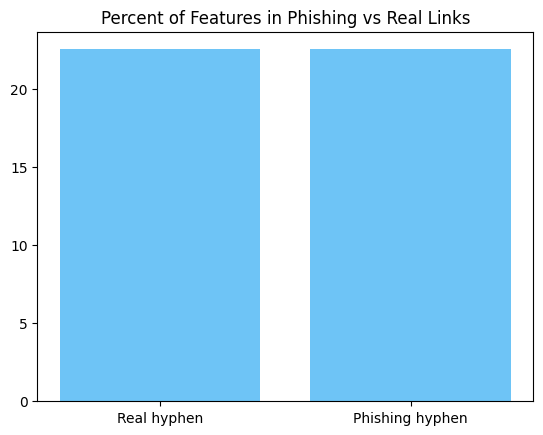

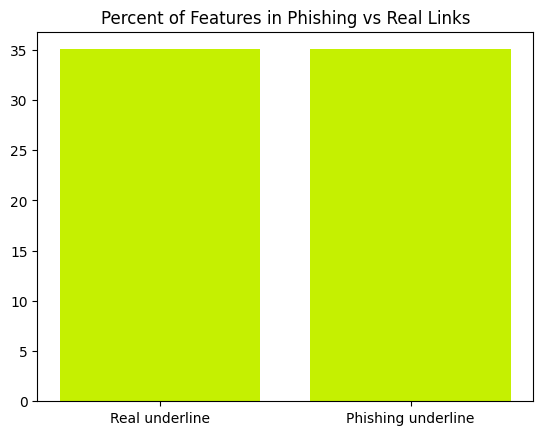

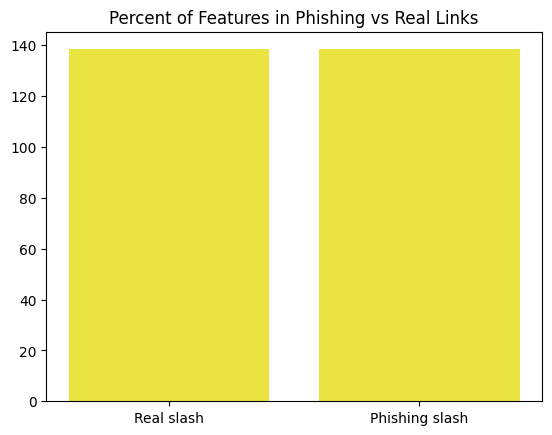

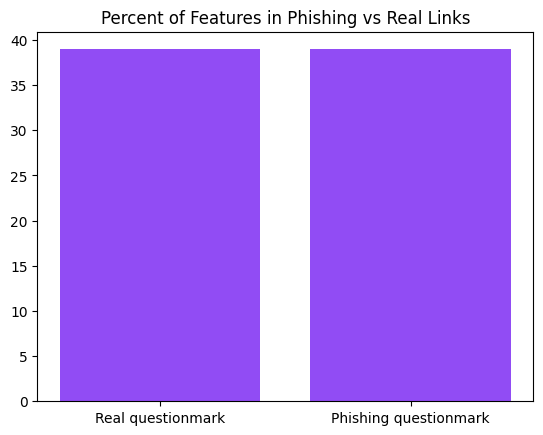

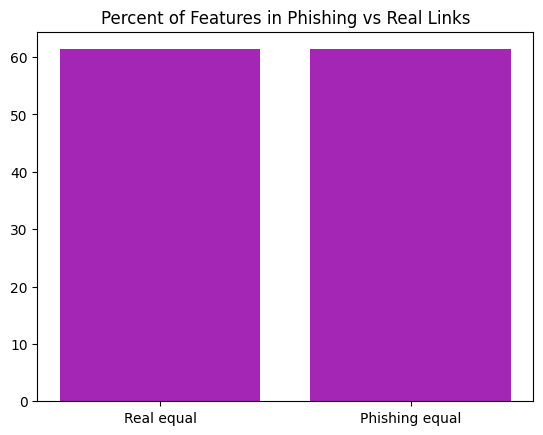

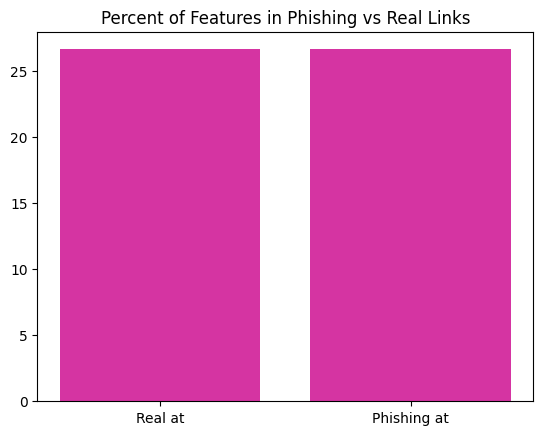

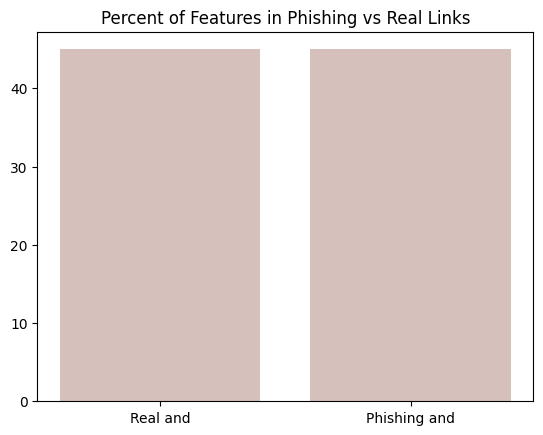

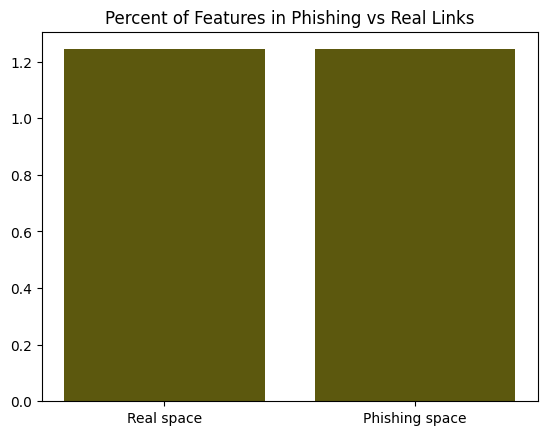

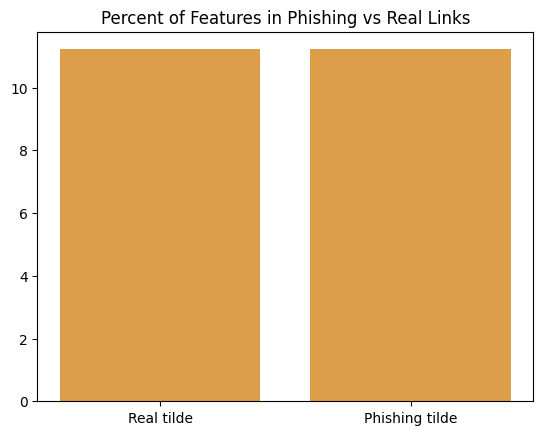

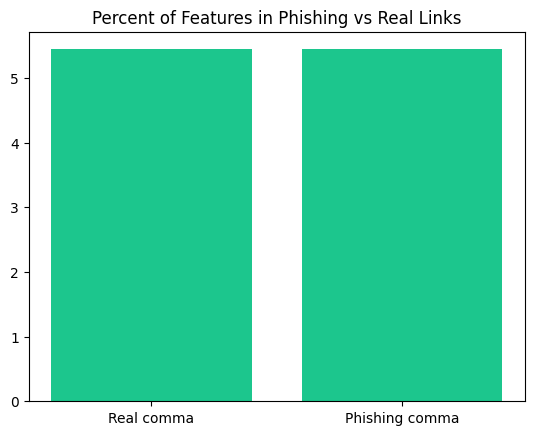

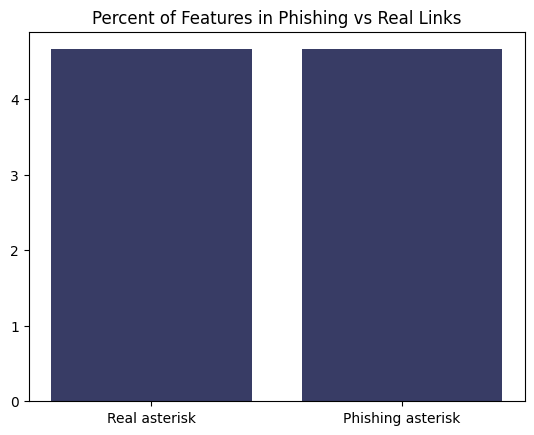

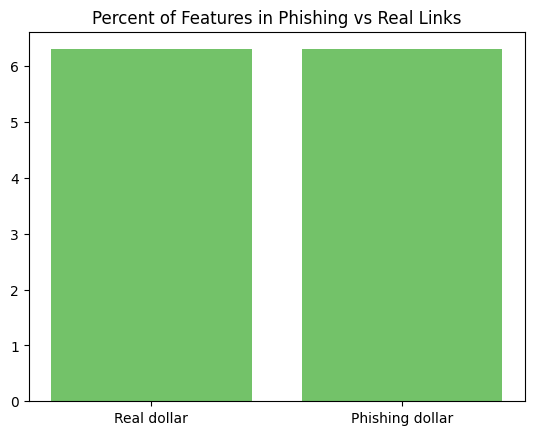

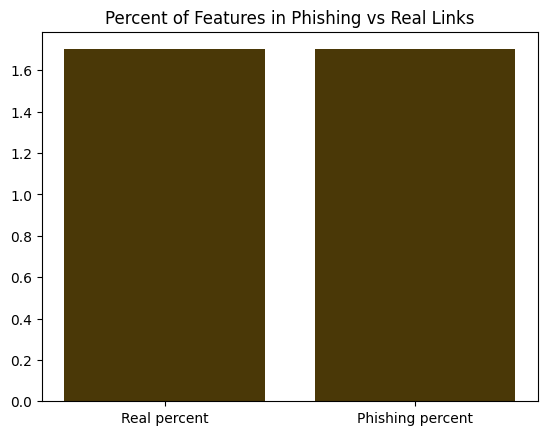

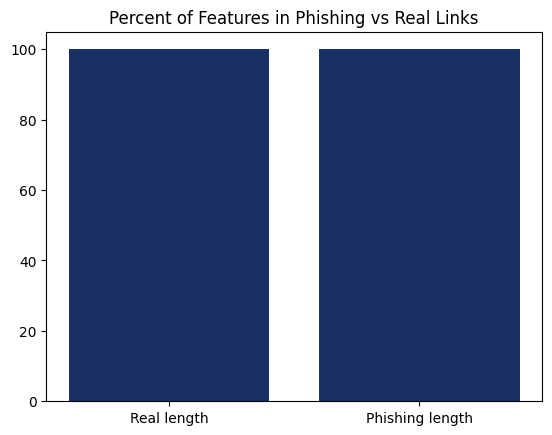

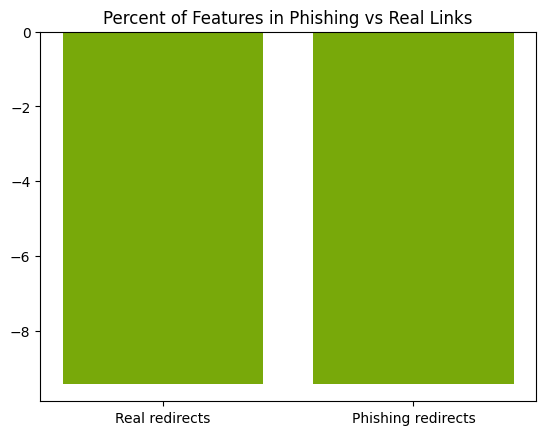

In [ ]:
# Creates a bar plot of the feature percentage
# Compares both Phishing and legimate precentages
for x in range(len(FEATURES)):
    plt.show()
    c = np.random.rand(3,)
    real_num = int(sum(df.loc[df[LABELS] == 0, FEATURES[x]]))
    phish_num = int(sum(df.loc[df[LABELS] == 1, FEATURES[x]]))
    plt.bar(("Real " + FEATURES[x]), (real_num / real_length), color=c)
    plt.bar(("Phishing " + FEATURES[x]), (phish_num / phish_length),
            color=c)
    plt.title("Percent of Features in Phishing vs Real Links")